In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Any
import logging

In [ ]:
from molencoder.evaluation.statistical_evaluation import repeated_measures_anova, tukey_hsd
from molencoder.utils.experiment_plotting import analyze_and_plot_experiments

In [36]:
def load_and_prepare_data_with_repeats(csv_path_1: str, csv_path_2: str) -> dict:
    """Load two CSV files and prepare data for each metric, combining them into one DataFrame."""
    # Load the CSV files
    df1 = pd.read_csv(csv_path_1)
    df2 = pd.read_csv(csv_path_2)
    
    # Add suffix to model names to distinguish between repeats
    df1['model'] = df1['model'] + '_repeat_1'
    df2['model'] = df2['model'] + '_repeat_2'
    
    # Combine the dataframes
    combined_df = pd.concat([df1, df2], ignore_index=True)
    
    # Create model name mapping for display (same style as utility function)
    model_name_mapping = {}
    for model in combined_df['model'].unique():
        if pd.isna(model):
            continue
        if '_repeat_1' in model:
            model_name_mapping[model] = "Run 1"
        elif '_repeat_2' in model:
            model_name_mapping[model] = "Run 2"
    
    # Map model names to display names
    combined_df['model'] = combined_df['model'].map(model_name_mapping)
    
    # Create a dictionary to store prepared data for each metric
    prepared_data = {}
    metrics = combined_df['metric_name'].unique()
    
    for metric in metrics:
        # Filter data for current metric
        metric_data = combined_df[combined_df['metric_name'] == metric]
        
        # Pivot the data to have models as columns and folds as rows
        pivot_data = metric_data.pivot(
            index='fold',
            columns='model',
            values='value'
        )
        
        prepared_data[metric] = pivot_data
    
    return prepared_data

def find_best_model(data: pd.DataFrame, metric_name: str) -> str:
    """Find the best performing model based on the metric values."""
    model_means = data.mean()
    
    if metric_name in ['mae', 'mse']:
        # For MAE and MSE, lower is better
        best_model = model_means.idxmin()
    else:
        # For R2 and rho, higher is better
        best_model = model_means.idxmax()
    
    return best_model

In [37]:
# Main analysis code
csv_path1 = "/Users/fabian/Code/smilesencoder/experiments/rerun_model/111M/adme-fang-HCLint-1_results_2.csv"
csv_path2 = "/Users/fabian/Code/smilesencoder/experiments/rerun_model/111M/adme-fang-HCLint-1_results.csv"

output_dir = Path("/Users/fabian/Code/smilesencoder/plots/repeated_run")
# Load and prepare the data
prepared_data = load_and_prepare_data_with_repeats(csv_path1, csv_path2)

# Extract dataset name (same logic as utility function)
dataset_name = (Path(csv_path1).stem
               .replace('_results', '')
               .replace('_results_2', '')
               .replace('adme-fang-', '')
               .replace('-1', '')
               .replace("hclint", "HClint")
               .replace("perm", "Perm")
               .replace("solu", "Solu")
               .replace("_2", " "))

Analysis for mae (p = 0.9716)
Best performing model for mae: Run 1
Saved PNG plot for mae to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _mae_repeated_runs.png
Saved PDF plot for mae to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _mae_repeated_runs.pdf


<Figure size 800x600 with 0 Axes>

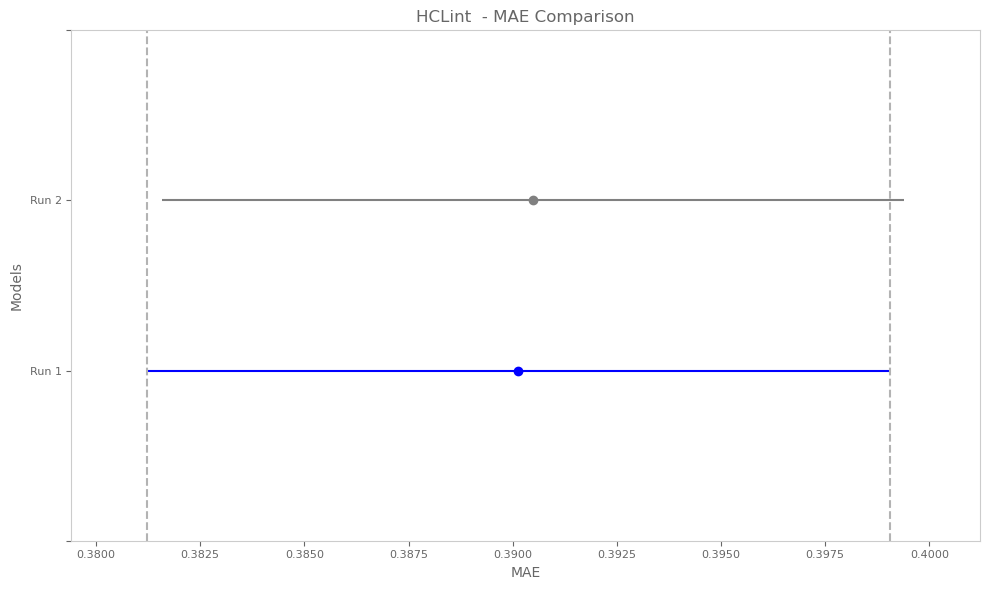

Analysis for mse (p = 0.9682)
Best performing model for mse: Run 2
Saved PNG plot for mse to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _mse_repeated_runs.png
Saved PDF plot for mse to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _mse_repeated_runs.pdf


<Figure size 800x600 with 0 Axes>

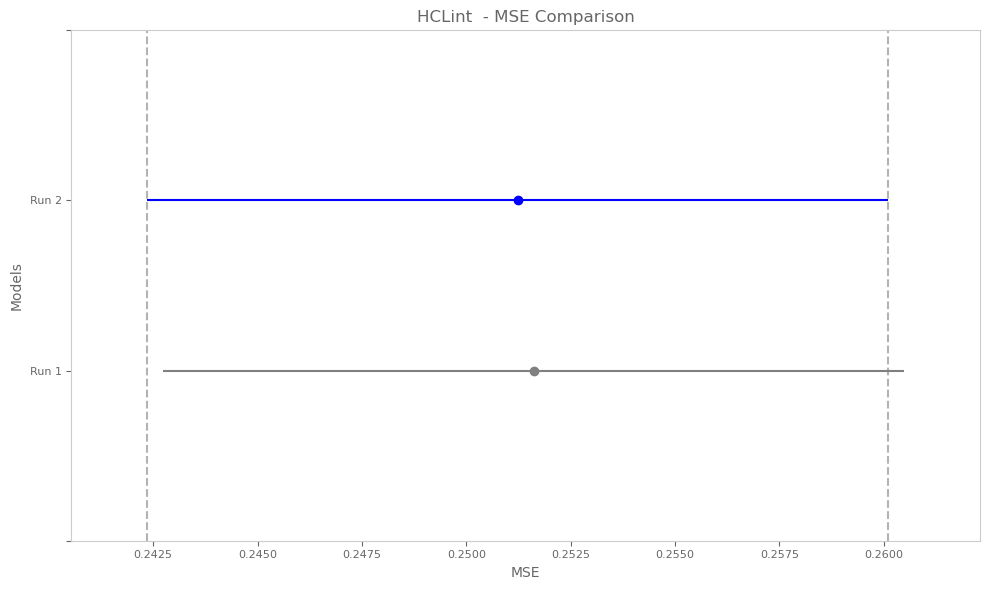

Analysis for r2 (p = 0.9761)
Best performing model for r2: Run 2
Saved PNG plot for r2 to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _r2_repeated_runs.png
Saved PDF plot for r2 to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _r2_repeated_runs.pdf


<Figure size 800x600 with 0 Axes>

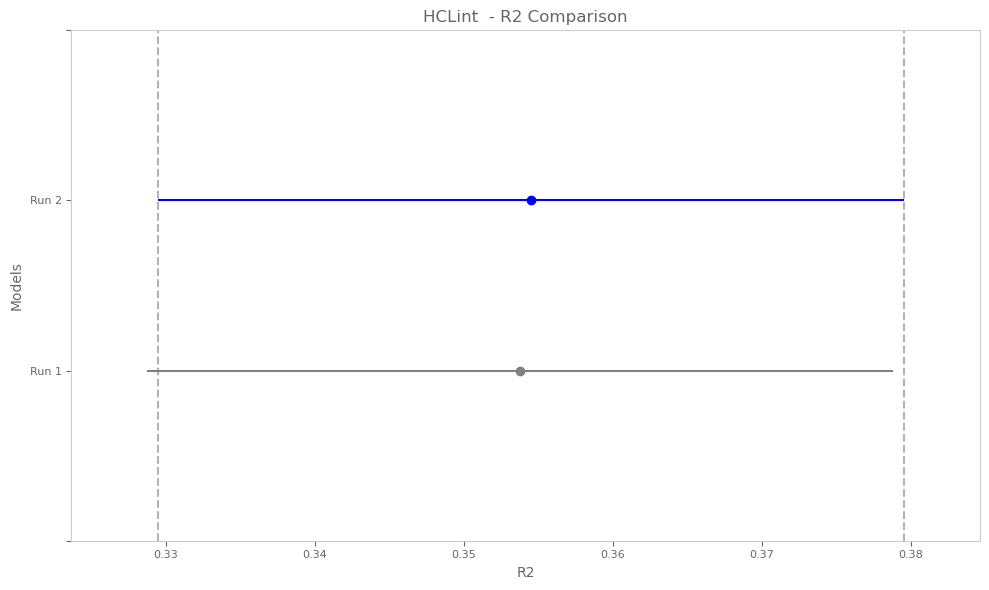

Analysis for rho (p = 0.9037)
Best performing model for rho: Run 2
Saved PNG plot for rho to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _rho_repeated_runs.png
Saved PDF plot for rho to /Users/fabian/Code/smilesencoder/plots/repeated_run/HCLint _rho_repeated_runs.pdf


<Figure size 800x600 with 0 Axes>

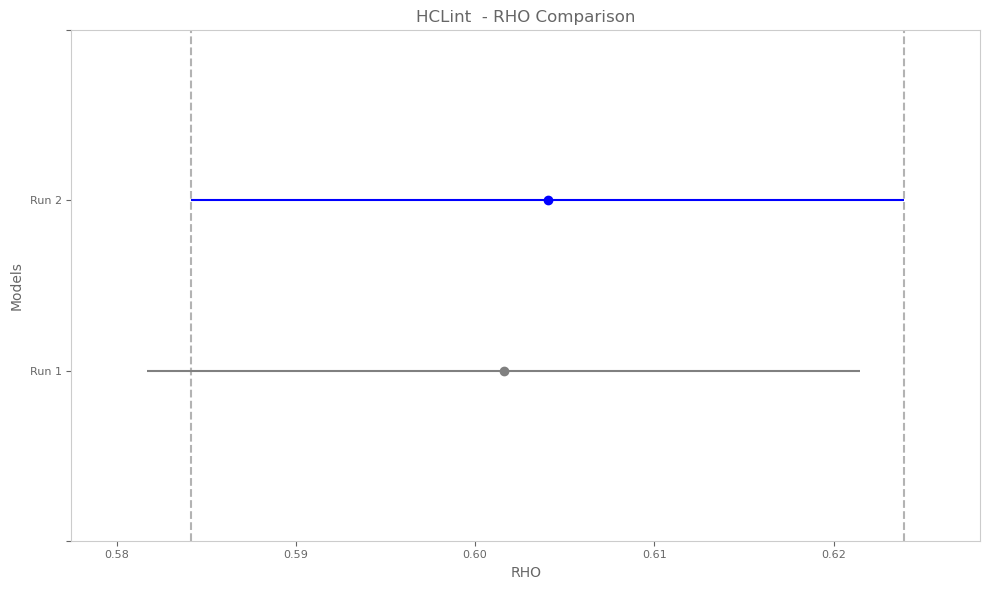

In [38]:
# Process each metric with same styling as utility function
for metric, data in prepared_data.items():
    try:
        # Perform repeated measures ANOVA
        anova_results = repeated_measures_anova(data)
        print(f"Analysis for {metric} (p = {anova_results['p_value']:.4f})")
        
        # Find the best performing model
        best_model = find_best_model(data, metric)
        print(f"Best performing model for {metric}: {best_model}")
        
        # Perform Tukey's HSD test
        tukey_results = tukey_hsd(data)
        
        # Create plot with same styling as utility function
        plt.figure(figsize=(8, 6))
        tukey_results['results'].plot_simultaneous(comparison_name=best_model)
        
        # Apply same styling as utility function
        plt.title(f"{dataset_name} - {metric.upper()} Comparison", fontsize=12, color='#666666')
        plt.xlabel(metric.upper(), fontsize=10, color='#666666')
        plt.ylabel('Models', fontsize=10, color='#666666')
        
        # Set tick parameters (same as utility function)
        plt.tick_params(axis='both', labelsize=8, colors='#666666')
        
        # Make borders light grey (same as utility function)
        for spine in plt.gca().spines.values():
            spine.set_color('#CCCCCC')
            spine.set_linewidth(0.8)
        
        plt.tight_layout()
        
        # Save the figure in both PDF and PNG formats if output_dir is provided
        if output_dir is not None:
            base_output_path = Path(output_dir) / f'{dataset_name}_{metric}_repeated_runs'
            
            # Save as PNG
            png_path = base_output_path.with_suffix('.png')
            plt.savefig(png_path, dpi=300, bbox_inches='tight')
            print(f"Saved PNG plot for {metric} to {png_path}")
            
            # Save as PDF
            pdf_path = base_output_path.with_suffix('.pdf')
            plt.savefig(pdf_path, bbox_inches='tight')
            print(f"Saved PDF plot for {metric} to {pdf_path}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing {metric}: {e}") 